In [61]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import copy
import seaborn as sns

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA
from sklearn.manifold import TSNE, MDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

Functions to output and save table, graph, and topic breakdowns given LDA model.

In [62]:
def topicBreakdown(df, lda, filename):
    vocab = df.columns
    taxonomy = pd.read_csv('../metag_topic_modeling/data_sets/HMP_V13_taxonomy_fix.csv')
    result = ''

    for i, comp in enumerate(lda.components_):
        vocab_comp = zip(vocab, comp)
        sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
        result += ("Topic "+str(i)+": ")
        for t in sorted_words:
            row = taxonomy[taxonomy['OTU_ID'] == t[0]]
            if not row.empty:
                result += (str(row.iat[0, 6]) + ' ')
            else:
                result += ("Not Found")
        result += ("\n")

    output_filename = f"results/{filename}_topic_breakdown.txt"
    with open(output_filename, 'w') as f:
        f.write(result)

    print(f"Topic breakdown saved to {output_filename}")
    print(result)

In [63]:
def bubblePlot1(df, lda, filename):
    vocab = df.columns
    taxonomy = pd.read_csv('../metag_topic_modeling/data_sets/HMP_V13_taxonomy_fix.csv')

    topic_data = []

    for i, comp in enumerate(lda.components_):
        vocab_comp = zip(vocab, comp)
        sorted_words = sorted(vocab_comp, key=lambda x: x[1], reverse=True)[:10]

        for otu_id, importance in sorted_words:
            row = taxonomy[taxonomy['OTU_ID'] == otu_id]
            if not row.empty:
                family_name = row.iat[0, 6]  # Assuming column index 4 corresponds to 'Family'
            else:
                family_name = "Not Found"

            topic_data.append({"Topic": f"Topic {i}", "Family": family_name, "Importance": importance})

    # Convert to DataFrame
    df_plot = pd.DataFrame(topic_data)

    # Sum importance values for each (Topic, Family) pair
    df_agg = df_plot.groupby(["Topic", "Family"], as_index=False).sum()

    # Bubble Plot
    plt.figure(figsize=(10, 6))
    bubble = sns.scatterplot(
        data=df_agg, x="Topic", y="Family", size="Importance", hue="Importance",
        sizes=(20, 1000), palette="viridis", edgecolor="black", alpha=0.7
    )

    plt.xticks(rotation=45)
    plt.xlabel("Topic")
    plt.ylabel("Taxonomic Family")
    plt.title("Bubble Plot of Taxonomic Families per Topic")
    plt.legend(title="Importance")
    plt.tight_layout()

    # Save and Show
    output_filename = f"results/{filename}_topic_bubble_plot.png"
    plt.savefig(output_filename, dpi=300)
    plt.show()

    print(f"Bubble plot saved to {output_filename}")

Original graph

In [64]:
body_sites = pd.read_csv('../metag_topic_modeling/data_sets/HMP_V13_participant_data.csv')

body_site_mapping = {site: idx for idx, site in enumerate(body_sites['HMP_BODY_SITE'].unique())}

body_site_ints = body_sites['HMP_BODY_SITE'].map(body_site_mapping)

In [65]:
def bubblePlot2(df, lda, filename):
    frequency_table = df.values
    topic_distributions = lda.transform(frequency_table)

    strongest_topic_indices = topic_distributions.argmax(axis=1)
    
    body_sites['Strongest_Topic'] = strongest_topic_indices

    # Compute topic counts by site
    topic_counts_by_site = body_sites.groupby(['HMP_BODY_SITE', 'Strongest_Topic']).size().reset_index(name="Count")

    print(topic_counts_by_site)

    # Save table to CSV
    table_filename = f"results/{filename}_table.csv"
    topic_counts_by_site.to_csv(table_filename, index=False)
    print(f"Table saved to {table_filename}")

    # Bubble Plot
    plt.figure(figsize=(12, 7))
    bubble = sns.scatterplot(
        data=topic_counts_by_site, x="Strongest_Topic", y="HMP_BODY_SITE", 
        size="Count", hue="Count",
        sizes=(20, 1000), palette="viridis", edgecolor="black", alpha=0.7
    )

    plt.xticks(rotation=45)
    plt.xlabel("Strongest Topic")
    plt.ylabel("Body Site")
    plt.title("Bubble Plot of Topic Assignments by Body Site")
    plt.legend(title="Sample Count", loc='upper right')
    plt.tight_layout()

    # Save and Show
    output_filename = f"results/{filename}_bubble_plot.png"
    plt.savefig(output_filename, dpi=300)
    plt.show()

    print(f"Bubble plot saved to {output_filename}")

In [66]:
df = pd.read_csv("../metag_topic_modeling/data_sets/HMP_V13_OTU_counts.csv")
df = df.drop(columns = ['PSN'])

# Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

# Initial dimensionality reduction
pca = PCA(n_components=50)
reduced_df = pca.fit_transform(scaled_df)

# Dimensionality reduction for visualization
tsne = TSNE(n_components=2, init='pca', random_state=0)
result = tsne.fit_transform(reduced_df)

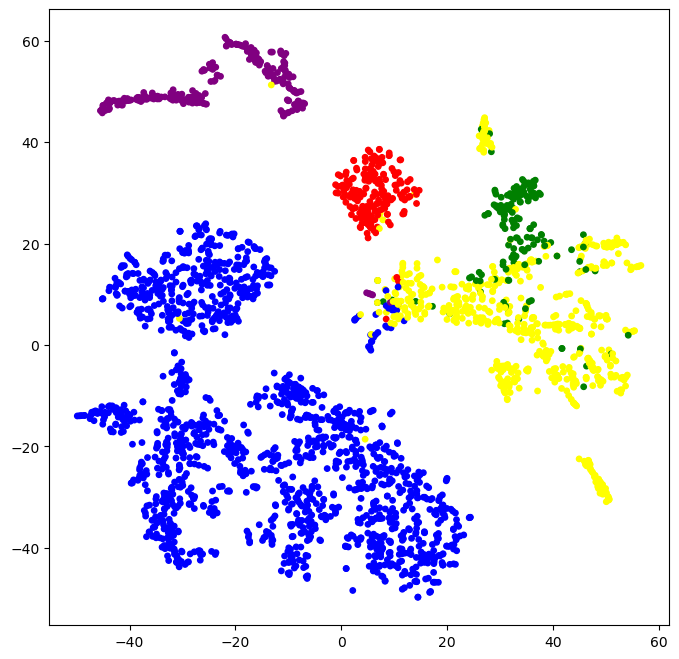

In [67]:
custom_colors = ['red', 'blue', 'green', 'yellow', 'purple']#, 'orange', 'pink', 'brown', 'olive', 'cyan']
cmap = ListedColormap(custom_colors)

# Plot with body sites
# Red = gut, blue = oral, green = airways, yellow = skin, purple = urogenital
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
scatter = plt.scatter(result[:, 0], result[:, 1], c=body_site_ints, cmap=cmap, s=15)
plt.savefig("body_site_plot.svg")
plt.show()

In [68]:
def outputTableandGraph(df, lda, filename):
    
    frequency_table = df.values
    topic_distributions = lda.transform(frequency_table)

    strongest_topic_indices = topic_distributions.argmax(axis=1)

    body_sites['Strongest_Topic'] = strongest_topic_indices

    topic_counts_by_site = body_sites.groupby(['HMP_BODY_SITE', 'Strongest_Topic']).size().unstack(fill_value=0)

    print(topic_counts_by_site)

    # Save table to CSV
    table_filename = f"results/{filename}_table.csv"
    topic_counts_by_site.to_csv(table_filename)
    print(f"Table saved to {table_filename}")

    LDA_mapping = {site: idx for idx, site in enumerate(body_sites['Strongest_Topic'].unique())}

    LDA_ints = body_sites['Strongest_Topic'].map(LDA_mapping)

    custom_colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'olive', 'cyan']
    cmap = ListedColormap(custom_colors)

    fig = plt.figure(1, figsize=(8, 8))
    plt.clf()
    scatter = plt.scatter(result[:, 0], result[:, 1], c=LDA_ints, cmap=cmap, s=15)
    plot_filename = f"results/{filename}_comp_plot_.svg"
    plt.savefig(plot_filename)
    print(f"Plot saved to {plot_filename}")
    plt.show()

Function to find optimal component number for each taxonomic level by perplexity, returning a graph and a table at that level.

In [69]:
def findComponentNum(file_name):
    df = pd.read_csv("data_sets/matrix/preprocessed_table_" + file_name + '.csv')
    df = df.drop(df.columns[0], axis=1)

    frequency_table = df.values

    bestLDA = LatentDirichletAllocation(n_components=5, random_state=0)
    bestLDA.fit(frequency_table)
    lowestPerplexity = bestLDA.perplexity(frequency_table)
    componentNum = 5
    print(componentNum, ',', lowestPerplexity, '\n')
    componentNum += 1


    decreasing = 1

    while decreasing == 1 and componentNum <= 10:
      LDA = LatentDirichletAllocation(n_components=componentNum, random_state=0)
      LDA.fit(frequency_table)
      perplexity = LDA.perplexity(frequency_table)

      print(componentNum, ', ', perplexity, '\n')
      
      if perplexity < lowestPerplexity:
        bestLDA = copy.deepcopy(LDA)
        lowestPerplexity = perplexity
      else:
        decreasing = 0

      componentNum += 1

    print('Component number:', componentNum - 2 + decreasing, ', Perplexity:', lowestPerplexity, '\n')

    return bestLDA, df

Combined function

In [70]:
def completeAnalysis(file_name):
    lda, df = findComponentNum(file_name)
    topicBreakdown(df, lda, file_name)
    bubblePlot1(df, lda, file_name)
    bubblePlot2(df, lda, file_name)
    outputTableandGraph(df, lda, file_name)

5 , 971.4172194010467 

6 ,  864.3298308223656 

7 ,  773.4735806594823 

8 ,  735.4077507785927 

9 ,  710.7672949302297 

10 ,  695.6840806217701 

Component number: 10 , Perplexity: 695.6840806217701 

Topic breakdown saved to results/00_topic_breakdown.txt
Topic 0: Lactobacillaceae Lactobacillaceae Lactobacillaceae Burkholderiaceae Streptococcaceae Neisseriaceae Lactobacillaceae Lactobacillaceae Streptococcaceae Neisseriaceae 
Topic 1: Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae 
Topic 2: Lactobacillaceae Burkholderiaceae nan Lactobacillaceae Lactobacillaceae Staphylococcaceae Lactobacillaceae Staphylococcaceae Neisseriaceae Lactobacillaceae 
Topic 3: Veillonellaceae Campylobacteraceae Neisseriaceae Veillonellaceae Streptococcaceae Carnobacteriaceae Veillonellaceae Streptococcaceae Neisseriaceae Prevotellaceae 
Topic 4: Propionibacteriaceae Propionibacteriac

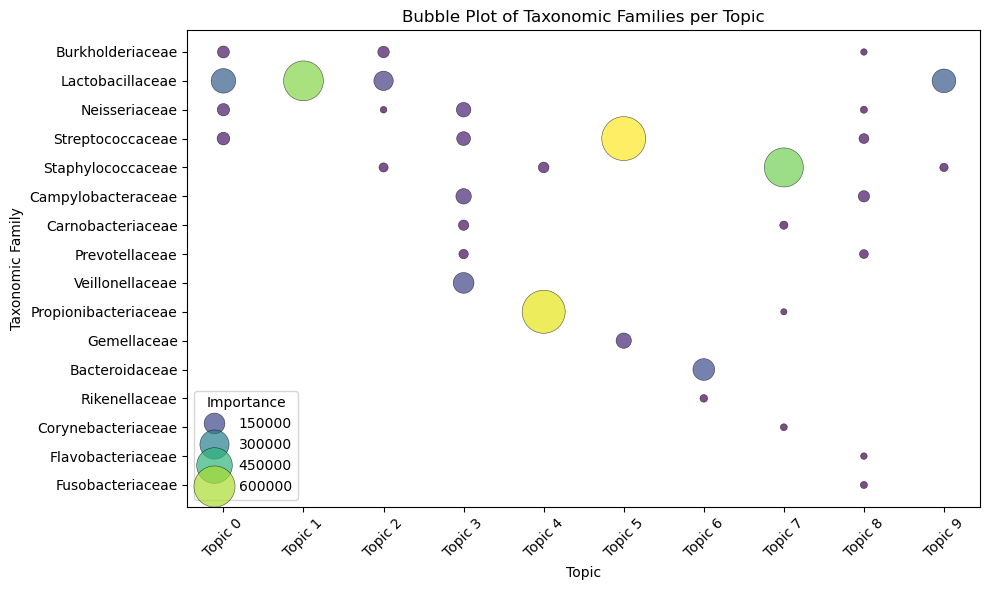

Bubble plot saved to results/00_topic_bubble_plot.png
             HMP_BODY_SITE  Strongest_Topic  Count
0                  Airways                1      1
1                  Airways                2     14
2                  Airways                3      1
3                  Airways                4     14
4                  Airways                5      1
5                  Airways                6      2
6                  Airways                7    128
7   Gastrointestinal Tract                5      1
8   Gastrointestinal Tract                6    185
9   Gastrointestinal Tract                7      1
10                    Oral                0    168
11                    Oral                2      3
12                    Oral                3    766
13                    Oral                5    426
14                    Oral                6      2
15                    Oral                7      2
16                    Oral                8    255
17                    Skin  

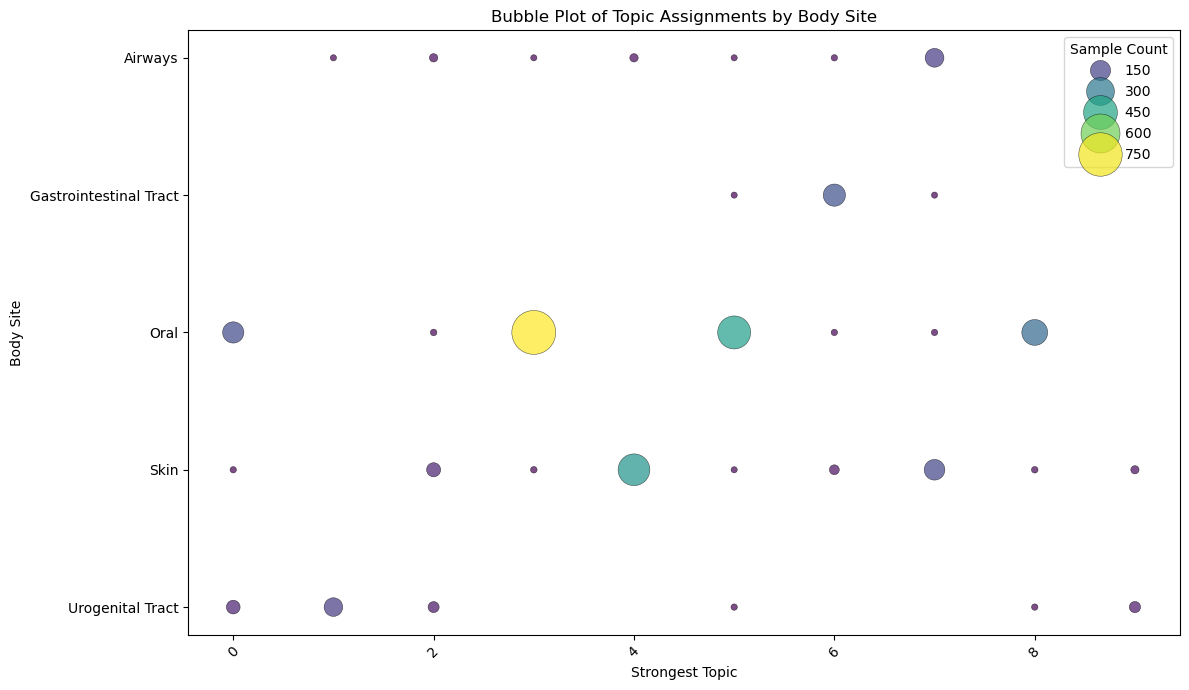

Bubble plot saved to results/00_bubble_plot.png
Strongest_Topic           0    1   2    3    4    5    6    7    8   9
HMP_BODY_SITE                                                         
Airways                   0    1  14    1   14    1    2  128    0   0
Gastrointestinal Tract    0    0   0    0    0    1  185    1    0   0
Oral                    168    0   3  766    0  426    2    2  255   0
Skin                      2    0  66    3  393    1   25  158    3  13
Urogenital Tract         62  126  35    0    0    2    0    0    2  37
Table saved to results/00_table.csv
Plot saved to results/00_comp_plot_.svg


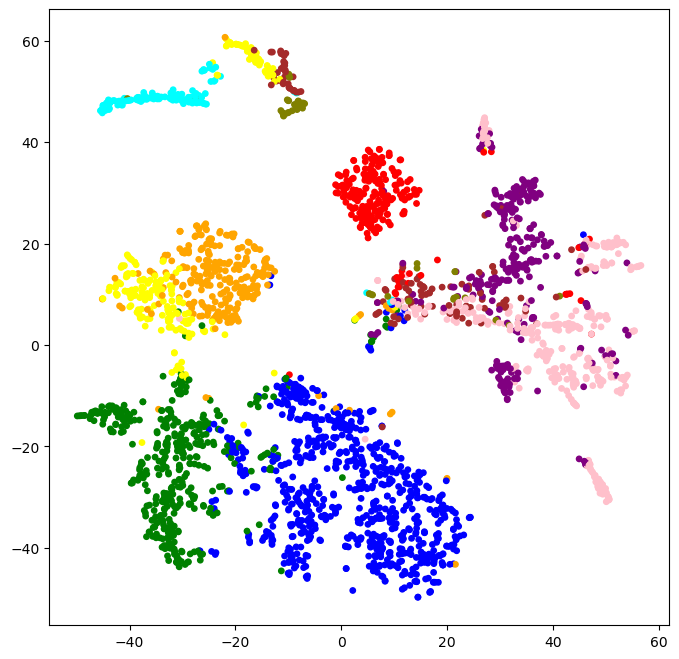

5 , 6333.431619872442 

6 ,  5771.8784570589105 

7 ,  5256.381389655483 

8 ,  5240.093735606381 

9 ,  5196.515227029163 

10 ,  5187.765438466361 

Component number: 10 , Perplexity: 5187.765438466361 

Topic breakdown saved to results/01_topic_breakdown.txt
Topic 0: Bacteroidaceae Bacteroidaceae Bacteroidaceae Bacteroidaceae Rikenellaceae Bacteroidaceae Lachnospiraceae Lachnospiraceae Bacteroidaceae Bacteroidaceae 
Topic 1: Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae 
Topic 2: Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae 
Topic 3: Veillonellaceae Campylobacteraceae Carnobacteriaceae Veillonellaceae Streptococcaceae Prevotellaceae Veillonellaceae Streptococcaceae Veillonellaceae Streptococcaceae 
Topic 4: Staphylococcaceae Propionibacte

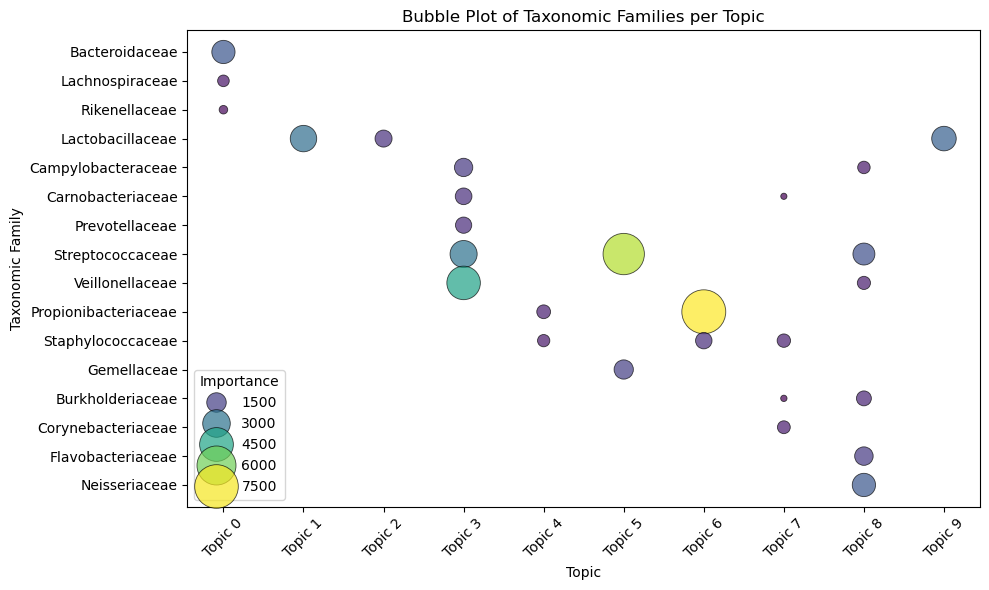

Bubble plot saved to results/01_topic_bubble_plot.png
             HMP_BODY_SITE  Strongest_Topic  Count
0                  Airways                3      1
1                  Airways                4     12
2                  Airways                5      1
3                  Airways                6     53
4                  Airways                7     93
5                  Airways                9      1
6   Gastrointestinal Tract                0    186
7   Gastrointestinal Tract                5      1
8                     Oral                0      1
9                     Oral                3    793
10                    Oral                4      2
11                    Oral                5    357
12                    Oral                8    469
13                    Skin                0     18
14                    Skin                3      4
15                    Skin                4     98
16                    Skin                5      3
17                    Skin  

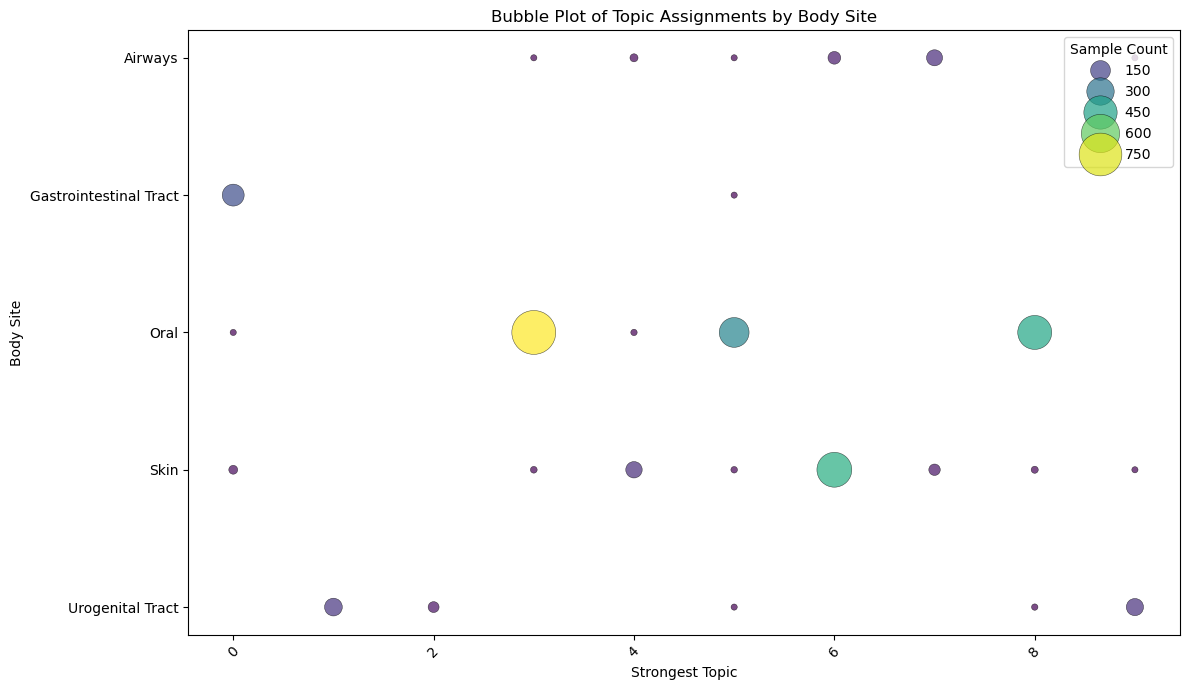

Bubble plot saved to results/01_bubble_plot.png
Strongest_Topic           0    1   2    3   4    5    6   7    8    9
HMP_BODY_SITE                                                        
Airways                   0    0   0    1  12    1   53  93    0    1
Gastrointestinal Tract  186    0   0    0   0    1    0   0    0    0
Oral                      1    0   0  793   2  357    0   0  469    0
Skin                     18    0   0    4  98    3  494  40    6    1
Urogenital Tract          0  117  35    0   0    1    0   0    2  109
Table saved to results/01_table.csv
Plot saved to results/01_comp_plot_.svg


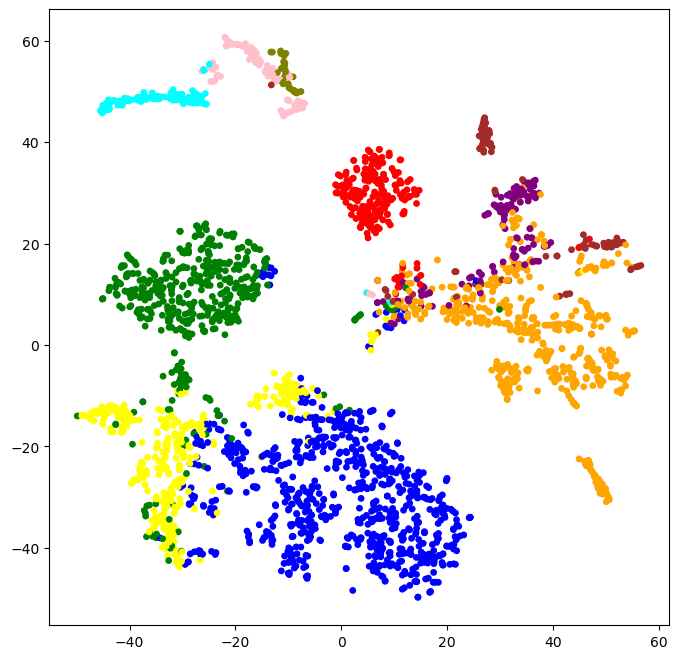

5 , 311493.20332425146 

6 ,  465547.2007313564 

Component number: 5 , Perplexity: 311493.20332425146 

Topic breakdown saved to results/02_topic_breakdown.txt
Topic 0: Streptococcaceae Streptococcaceae Streptococcaceae Veillonellaceae Campylobacteraceae Lactobacillaceae Gemellaceae Streptococcaceae Neisseriaceae Lactobacillaceae 
Topic 1: Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Coriobacteriaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae 
Topic 2: Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae 
Topic 3: Fusobacteriaceae Lachnospiraceae Propionibacteriaceae Staphylococcaceae Bacillaceae Streptococcaceae Helicobacteraceae Clostridiaceae Listeriaceae Alcaligenaceae 
Topic 4: Staphylococcaceae Propionibacteriaceae Propionibacteriaceae nan Propionibacteriaceae Burkholderiaceae Staphylococcaceae Prop

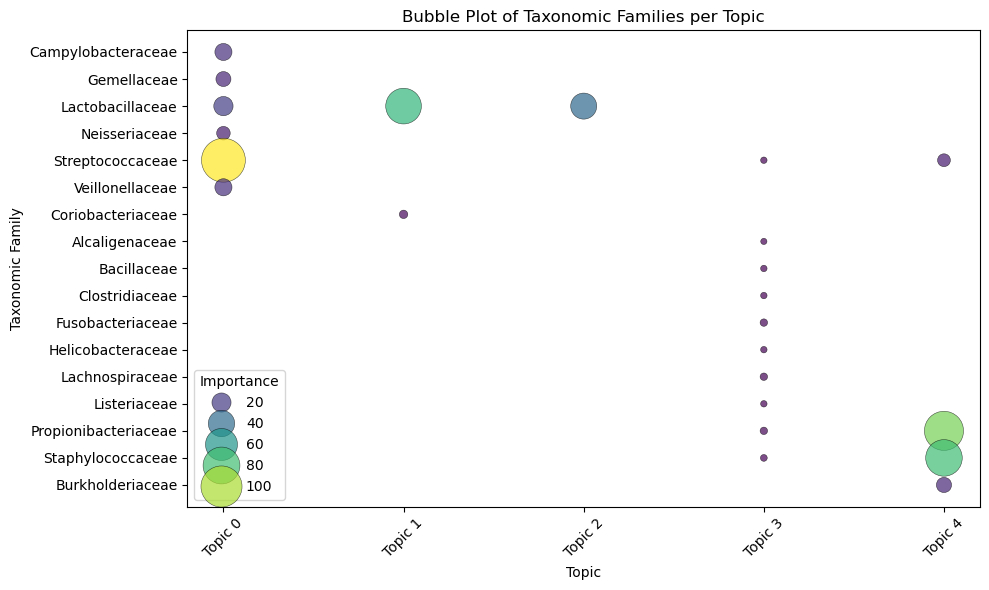

Bubble plot saved to results/02_topic_bubble_plot.png
             HMP_BODY_SITE  Strongest_Topic  Count
0                  Airways                0      1
1                  Airways                1      1
2                  Airways                4    159
3   Gastrointestinal Tract                0      1
4   Gastrointestinal Tract                4    186
5                     Oral                0   1242
6                     Oral                1      2
7                     Oral                2      2
8                     Oral                4    376
9                     Skin                0      5
10                    Skin                1      1
11                    Skin                2      1
12                    Skin                3      3
13                    Skin                4    654
14        Urogenital Tract                0     72
15        Urogenital Tract                1    126
16        Urogenital Tract                2     65
17        Urogenital Tract  

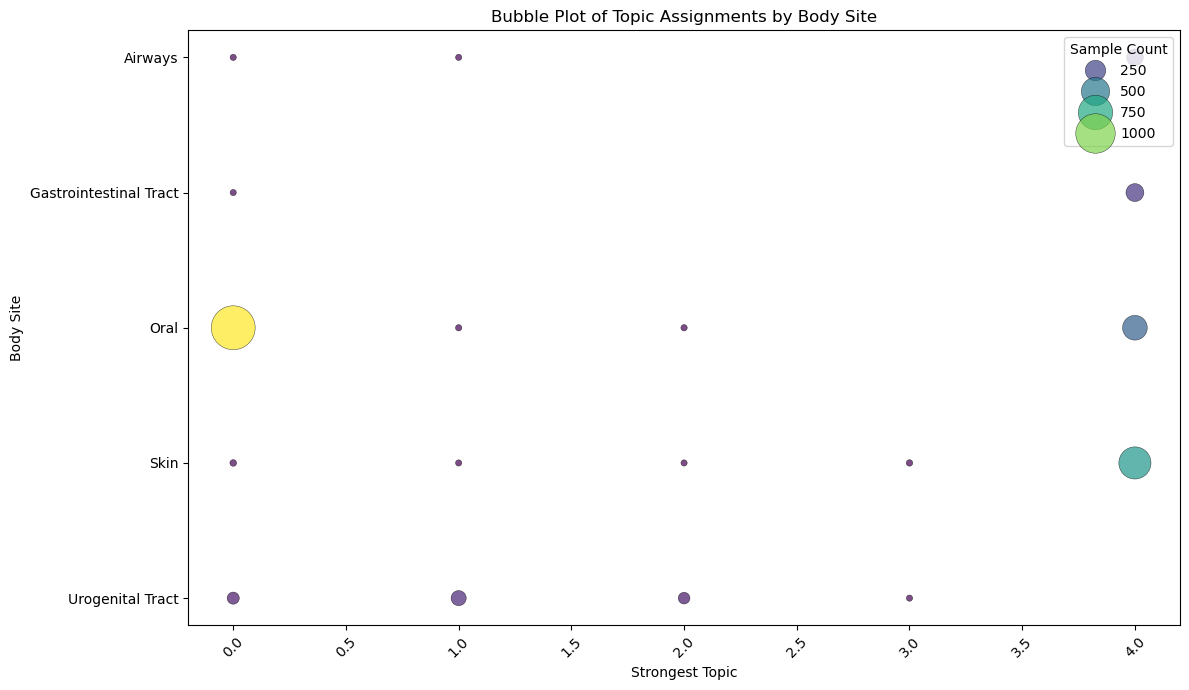

Bubble plot saved to results/02_bubble_plot.png
Strongest_Topic            0    1   2  3    4
HMP_BODY_SITE                                
Airways                    1    1   0  0  159
Gastrointestinal Tract     1    0   0  0  186
Oral                    1242    2   2  0  376
Skin                       5    1   1  3  654
Urogenital Tract          72  126  65  1    0
Table saved to results/02_table.csv
Plot saved to results/02_comp_plot_.svg


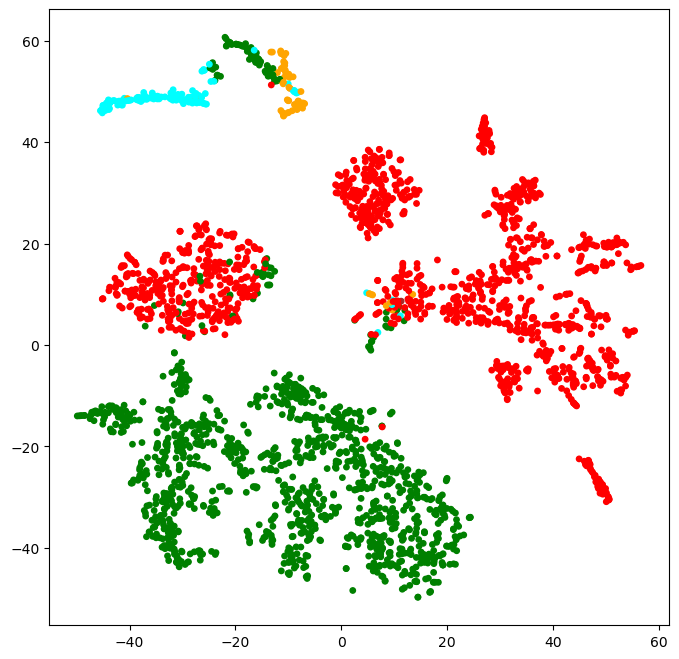

5 , 33278.0831448567 

6 ,  50077.040775656555 

Component number: 5 , Perplexity: 33278.0831448567 

Topic breakdown saved to results/10_topic_breakdown.txt
Topic 0: Veillonellaceae Campylobacteraceae Neisseriaceae Veillonellaceae Streptococcaceae Carnobacteriaceae Veillonellaceae Streptococcaceae Prevotellaceae Neisseriaceae 
Topic 1: Staphylococcaceae Lactobacillaceae Propionibacteriaceae Propionibacteriaceae nan Propionibacteriaceae Burkholderiaceae Staphylococcaceae Propionibacteriaceae Staphylococcaceae 
Topic 2: Streptococcaceae Streptococcaceae Streptococcaceae Lactobacillaceae Gemellaceae Burkholderiaceae Streptococcaceae Streptococcaceae Streptococcaceae Neisseriaceae 
Topic 3: Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Coriobacteriaceae 
Topic 4: Streptococcaceae Bacillaceae Streptococcaceae Prevotellaceae Gemellaceae Prevotellaceae Streptococcaceae Veillonellaceae V

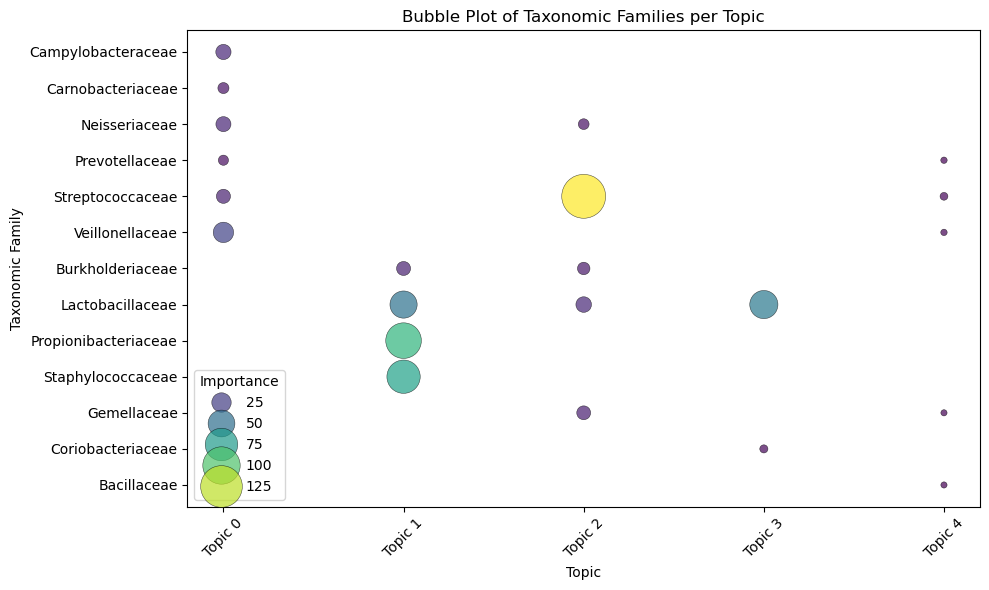

Bubble plot saved to results/10_topic_bubble_plot.png
             HMP_BODY_SITE  Strongest_Topic  Count
0                  Airways                0      1
1                  Airways                1    159
2                  Airways                2      1
3   Gastrointestinal Tract                1    186
4   Gastrointestinal Tract                2      1
5                     Oral                0    791
6                     Oral                1      5
7                     Oral                2    824
8                     Oral                3      1
9                     Oral                4      1
10                    Skin                0      5
11                    Skin                1    654
12                    Skin                2      5
13        Urogenital Tract                0      1
14        Urogenital Tract                1    116
15        Urogenital Tract                2     35
16        Urogenital Tract                3    112
Table saved to results/10_ta

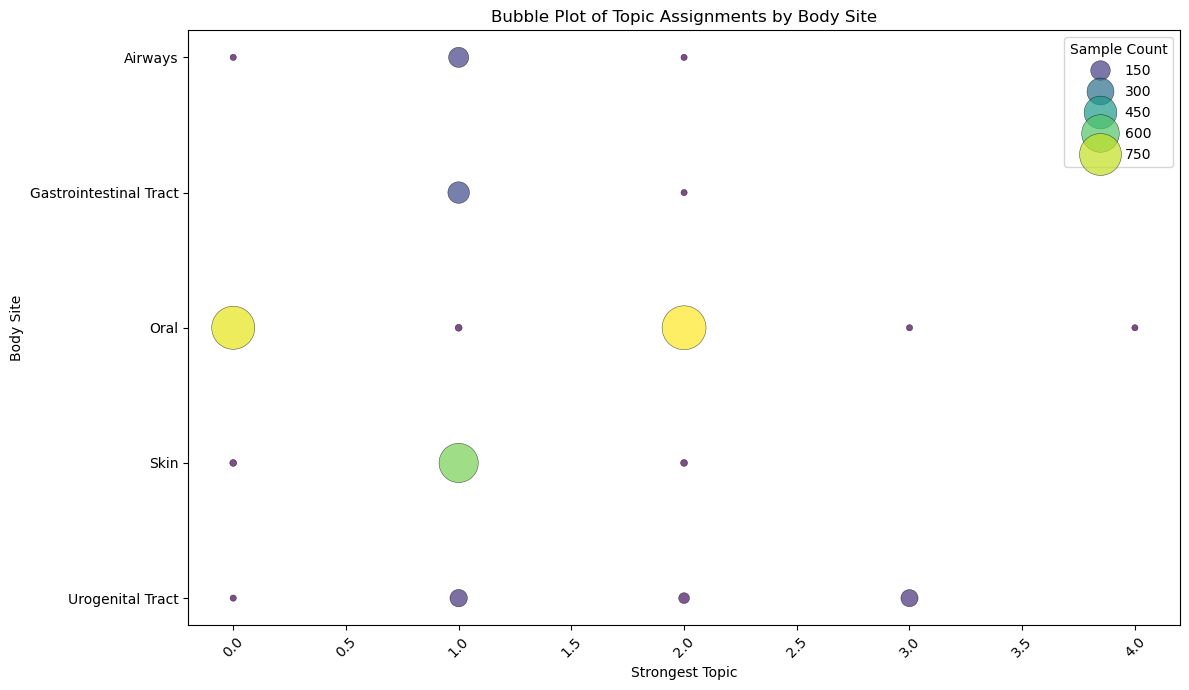

Bubble plot saved to results/10_bubble_plot.png
Strongest_Topic           0    1    2    3  4
HMP_BODY_SITE                                
Airways                   1  159    1    0  0
Gastrointestinal Tract    0  186    1    0  0
Oral                    791    5  824    1  1
Skin                      5  654    5    0  0
Urogenital Tract          1  116   35  112  0
Table saved to results/10_table.csv
Plot saved to results/10_comp_plot_.svg


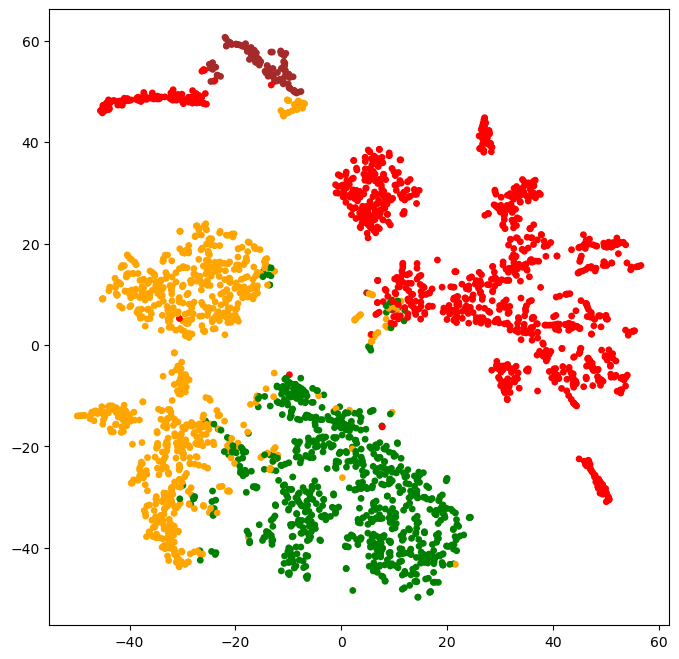

5 , 172888.4921856737 

6 ,  336274.63372631266 

Component number: 5 , Perplexity: 172888.4921856737 

Topic breakdown saved to results/11_topic_breakdown.txt
Topic 0: Veillonellaceae Campylobacteraceae Neisseriaceae Streptococcaceae Veillonellaceae Carnobacteriaceae Veillonellaceae Streptococcaceae Veillonellaceae Neisseriaceae 
Topic 1: Staphylococcaceae Propionibacteriaceae Lactobacillaceae Propionibacteriaceae nan Propionibacteriaceae Burkholderiaceae Staphylococcaceae Propionibacteriaceae Staphylococcaceae 
Topic 2: Streptococcaceae Streptococcaceae Streptococcaceae Lactobacillaceae Gemellaceae Streptococcaceae Burkholderiaceae Streptococcaceae Streptococcaceae Neisseriaceae 
Topic 3: Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae 
Topic 4: Bacillaceae Streptococcaceae Prevotellaceae Veillonellaceae Streptococcaceae Porphyromonadaceae Streptococcaceae Strepto

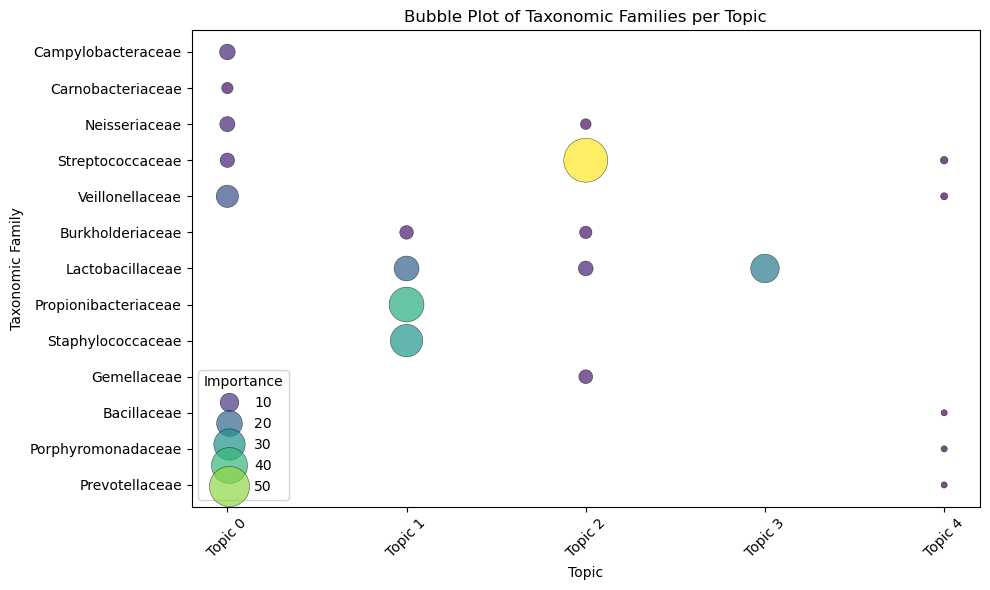

Bubble plot saved to results/11_topic_bubble_plot.png
             HMP_BODY_SITE  Strongest_Topic  Count
0                  Airways                0      1
1                  Airways                1    159
2                  Airways                2      1
3   Gastrointestinal Tract                1    186
4   Gastrointestinal Tract                2      1
5                     Oral                0    800
6                     Oral                1      5
7                     Oral                2    817
8                     Skin                0      5
9                     Skin                1    655
10                    Skin                2      4
11        Urogenital Tract                0      1
12        Urogenital Tract                1    115
13        Urogenital Tract                2     35
14        Urogenital Tract                3    113
Table saved to results/11_table.csv


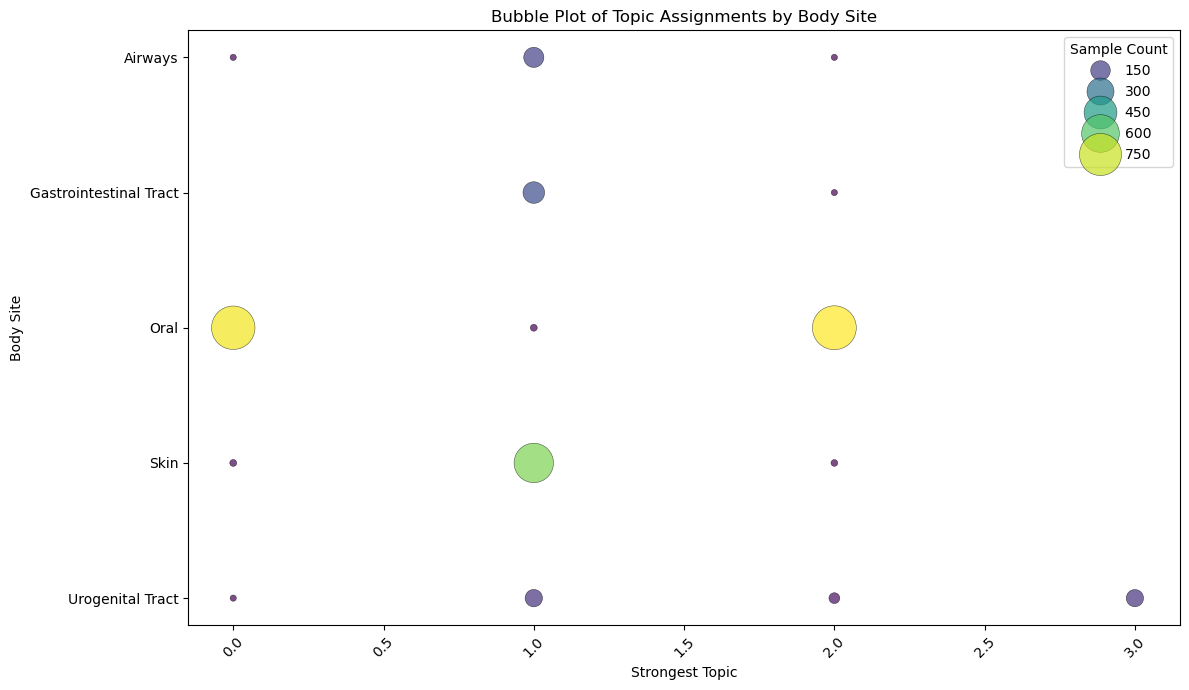

Bubble plot saved to results/11_bubble_plot.png
Strongest_Topic           0    1    2    3
HMP_BODY_SITE                             
Airways                   1  159    1    0
Gastrointestinal Tract    0  186    1    0
Oral                    800    5  817    0
Skin                      5  655    4    0
Urogenital Tract          1  115   35  113
Table saved to results/11_table.csv
Plot saved to results/11_comp_plot_.svg


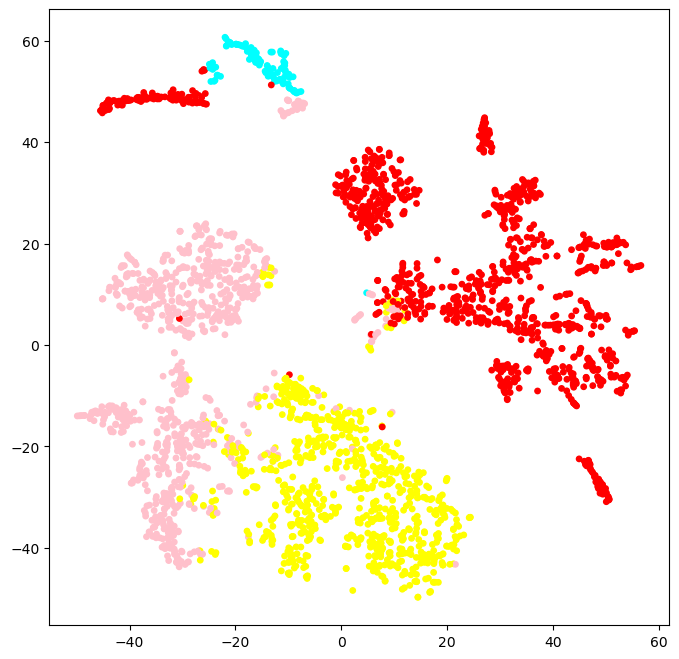

5 , 25961.388829159438 

6 ,  37368.740323213104 

Component number: 5 , Perplexity: 25961.388829159438 

Topic breakdown saved to results/12_topic_breakdown.txt
Topic 0: Veillonellaceae Campylobacteraceae Neisseriaceae Veillonellaceae Streptococcaceae Carnobacteriaceae Veillonellaceae Streptococcaceae Prevotellaceae Neisseriaceae 
Topic 1: Staphylococcaceae Lactobacillaceae Propionibacteriaceae Propionibacteriaceae nan Propionibacteriaceae Burkholderiaceae Staphylococcaceae Propionibacteriaceae Bacteroidaceae 
Topic 2: Streptococcaceae Streptococcaceae Streptococcaceae Lactobacillaceae Gemellaceae Burkholderiaceae Streptococcaceae Streptococcaceae Streptococcaceae Neisseriaceae 
Topic 3: Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Lactobacillaceae Coriobacteriaceae Lactobacillaceae Lactobacillaceae 
Topic 4: Streptococcaceae Streptococcaceae Lactobacillaceae Veillonellaceae Streptococcaceae Streptococcaceae Prevotellaceae Strep

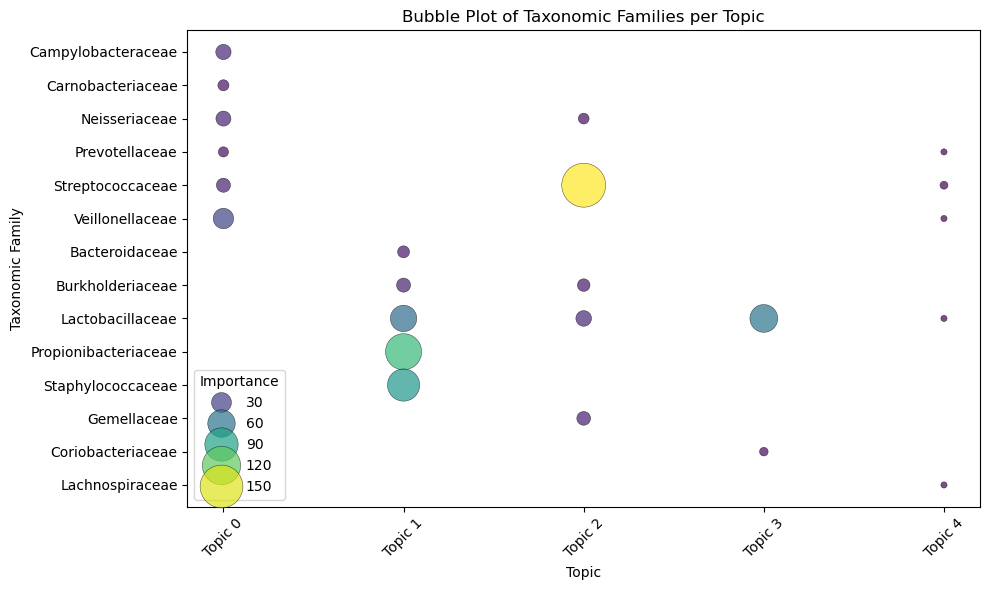

Bubble plot saved to results/12_topic_bubble_plot.png
             HMP_BODY_SITE  Strongest_Topic  Count
0                  Airways                0      1
1                  Airways                1    159
2                  Airways                2      1
3   Gastrointestinal Tract                1    186
4   Gastrointestinal Tract                2      1
5                     Oral                0    782
6                     Oral                1      5
7                     Oral                2    833
8                     Oral                3      1
9                     Oral                4      1
10                    Skin                0      5
11                    Skin                1    654
12                    Skin                2      5
13        Urogenital Tract                0      1
14        Urogenital Tract                1    115
15        Urogenital Tract                2     35
16        Urogenital Tract                3    113
Table saved to results/12_ta

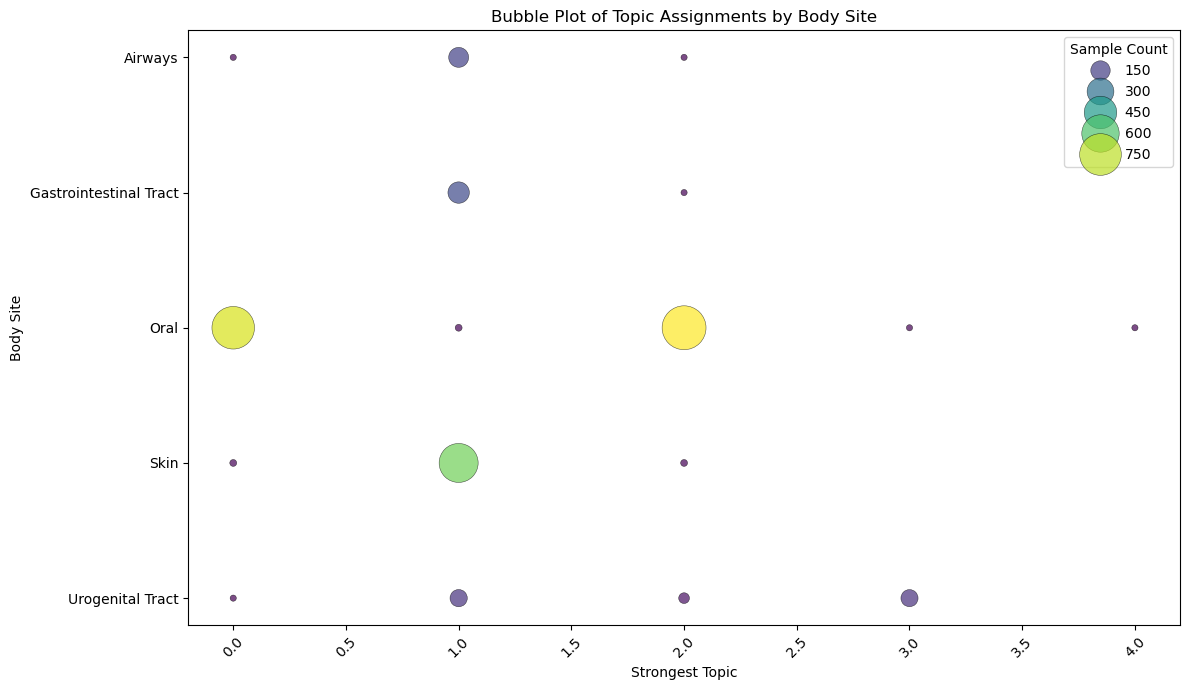

Bubble plot saved to results/12_bubble_plot.png
Strongest_Topic           0    1    2    3  4
HMP_BODY_SITE                                
Airways                   1  159    1    0  0
Gastrointestinal Tract    0  186    1    0  0
Oral                    782    5  833    1  1
Skin                      5  654    5    0  0
Urogenital Tract          1  115   35  113  0
Table saved to results/12_table.csv
Plot saved to results/12_comp_plot_.svg


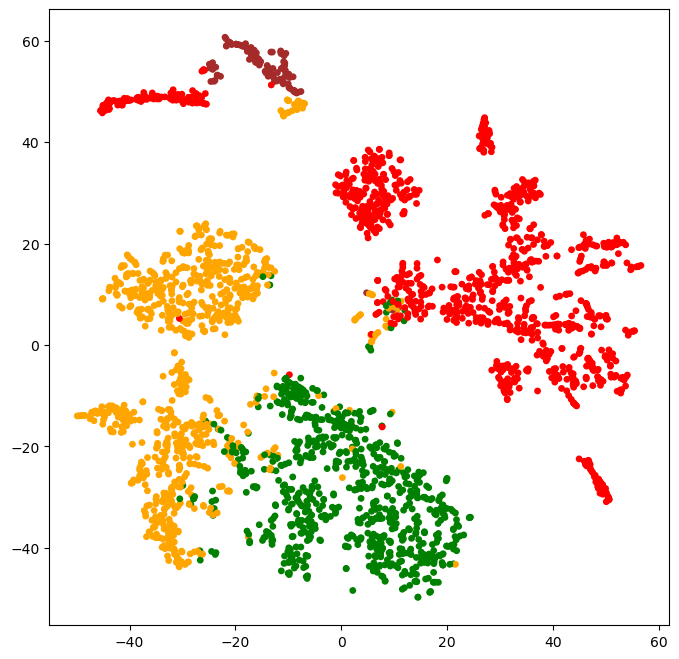

In [71]:
for i in [0,1]:
    for j in [0,1,2]:
        completeAnalysis(f"{i}{j}")